In [2]:
from __future__ import print_function

import os,sys,math
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.models import Model
from keras.datasets import mnist
from keras.layers import *
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras.utils.np_utils import to_categorical
from tensorflow.keras.utils import plot_model
from os import listdir
from sklearn.model_selection import train_test_split


#nnscript = os.path.abspath('../../../../Scripts/NNFunctions')
#sys.path.append(nnscript)
from fully_connected_opt_weight_generation import *
%matplotlib inline
workspace = '../'
dataset_path = '/sign_language_data_set'
datapath = workspace + dataset_path
output = workspace + '/code'
listdir(datapath)

['x.csv', 'x_45.csv', 'y.csv', 'y_45.csv']

In [3]:
def showP(d, f, n=None):
    if(n==None):
        R = 1
    else:
        R = n
    for i in range(R):
        if(i%10==0):
            N = R-i
            if(N > 10): N = 10
            fig, axs = plt.subplots(1, 10)
        I = i + f
        im = np.asarray(d[0][I]).reshape(45,45)
        try:
            ax = axs[i%N]
        except:
            ax = axs
        ax.imshow(im,cmap='gray', vmin=0, vmax=255)
        label =  d[1][I].argmax()
        ax.set_title(label)

def f2q(d, Q):
    '''To convert a number from floating point to Qm.n format:
        1. Multiply the floating point number by 2n
        2. Round to the nearest integer
    '''
    if(type(d) is list):
        D = []
        for v in d:
            D.append(int(v*math.pow(2,Q)+0.5))
    elif(type(d) is np.ndarray):
        D = int(d*math.pow(2,Q)+0.5)
    else:
        D = int(d*math.pow(2,Q)+0.5)
    return D

def ToList(d):
    sz=1
    for s in d.shape:
        sz = sz*s
    return d.reshape(sz).tolist()

def q2f(d, Q):
    '''To convert a number from Qm.n format to floating point:
        1. Convert the number to floating point as if it were an integer, in other words remove the binary point
        2. Multiply by 2−n
    '''
    if(type(d) is np.ndarray):
        d = ToList(d)
    if(type(d) is list):
        D = []
        for v in d:
            D.append(float(v*math.pow(2,-Q)))
    elif(type(d) is np.ndarray):
        D = d*math.pow(2,-Q)
    else:
        D = float(d*math.pow(2,-Q))
    return D

def save_as_is(w,name,macro='',prefix=''):
    
    if(type(w) is np.ndarray):
        aL = ToList(w)
    else:
        aL = list(w)
    
    qL = np.asarray(aL)
    #qL.tofile('tmp/%s.raw'%(name))
    fp1 = open(output+'/%s.h'%(name),'a')
    if macro != '':                
        fp1.write(prefix+'#define '+macro + ' {')
        
    qL.tofile(fp1, sep=',', format='%d')
    
    if macro != '':
        fp1.write('}\n')
    fp1.close()   


def save(w,name,macro='',prefix=''):
    
    if(type(w) is np.ndarray):
        aL = ToList(w)
    else:
        aL = list(w)
    MIN,MAX=min(aL),max(aL)
    Q = int(np.ceil(np.log2(max(abs(MIN),abs(MAX)))))
    Q = 7-Q
    qL = np.asarray(f2q(aL,Q),np.int8)
    #qL.tofile('tmp/%s.raw'%(name))
    fp1 = open(output+'/%s.h'%(name),'a')
    if macro != '':                
        fp1.write(prefix+'#define '+macro + ' {')
        
    qL.tofile(fp1, sep=',', format='%d')
    
    if macro != '':
        fp1.write('}\n')
    fp1.close()
        
    return qL,Q

def showW(w, name):
    if(type(w) is np.ndarray):
        aL = ToList(w)
    else:
        aL = list(w)
    MIN,MAX=min(aL),max(aL)
    Q = int(np.ceil(np.log2(max(abs(MIN),abs(MAX)))))
    Q = 7-Q
    qL = np.asarray(f2q(aL,Q),np.int8)
    qL = q2f(ToList(qL),Q)
    plt.figure(figsize=(18, 3))  
    plt.subplot(131)
    plt.title(name)
    plt.plot(aL)
    plt.grid()
    aL.sort()
    plt.plot(aL,'r')
    plt.grid()
    plt.subplot(132)
    plt.title('Q%s'%(Q))
    qL.sort()
    plt.plot(aL,'r')
    plt.plot(qL,'g')
    plt.grid()
    plt.subplot(133)
    plt.hist(aL,100)
    plt.title('hist')
    plt.grid()
    plt.show()

def show(a1, a2=None, a3=None):
    if(type(a2) == str):
        showW(a1, a2)
    else:
        showP(a1, a2, a3)


def compare(a,b,name):
    if(type(a) is np.ndarray):
        aL = ToList(a)
    else:
        aL = list(a)
    if(type(b) is np.ndarray):
        bL = ToList(b)
    else:
        bL = list(b)
    assert(len(aL) == len(bL))
    Z = list(zip(aL,bL))
    Z.sort(key=lambda x: x[0])
    aL1,bL1=zip(*Z)
    plt.figure(figsize=(18, 3))
    plt.subplot(131)
    plt.plot(aL)
    plt.plot(aL1,'r')
    plt.grid()
    plt.title('tf-%s'%(name))
    plt.subplot(133)
    plt.plot(bL1,'g')
    plt.plot(aL1,'r')
    plt.grid()
    plt.title('compare')
    plt.subplot(132)
    bL1=list(bL1)
    bL1.sort()
    plt.plot(bL)
    plt.plot(bL1,'g')
    plt.grid()
    plt.title('nn-%s'%(name))

def RunSysCmd(cmd):
    import subprocess
    p = subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True)
    (output, err) = p.communicate()
    p_status = p.wait()
    print(output.decode('utf-8'))

def Download(url, force=False):
    tgt = os.path.basename(url)
    if(os.path.exists(tgt) and force):
        RunSysCmd('rm -f %s'%(tgt))
    if(not os.path.exists(tgt)):
        RunSysCmd('wget %s'%(url))
    return tgt

data: (2050, 2025) labels:  (2050, 10)
test labels:  [0 1 3 5 7 9]
(2050, 45, 45)


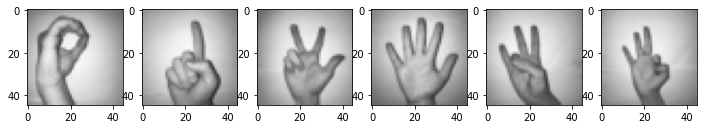

In [4]:
X = np.genfromtxt(datapath+'/x_45.csv', delimiter=',')
Y = np.genfromtxt(datapath+'/y_45.csv', delimiter=',')
test_rows = np.arange(0, X.shape[0], 400)
nrows = len(test_rows)
test_rows
nrows
print('data:', X.shape, 'labels: ', Y.shape)
print('test labels: ', np.argmax(Y[test_rows], axis=1))

plt.figure(figsize=(12,8))
for i in range(0, nrows): 
    plt.subplot(1,nrows,i+1)
    plt.imshow(X[test_rows[i]].reshape(45,45),cmap='gray', vmin=0, vmax=255)
    
X_reshaped= X.reshape(X.shape[0],45, 45)
print(X_reshaped.shape)

In [5]:
#https://adventuresinmachinelearning.com/keras-tutorial-cnn-11-lines/
def KModel():
    pd_str= 'same'
    model2d = Sequential()
    #1st convolution layer
    model2d.add(Conv2D(32,kernel_size=(5,5), padding=pd_str, input_shape=(45,45,1), name='conv2d_1'))
    #using RelU activation
    model2d.add(Activation('relu'))
    #using MaxPooling
    model2d.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding=pd_str))

    #2st convolution layer
    model2d.add(Conv2D(32, (5,5), padding=pd_str, name="conv2d_2"))
    model2d.add(Activation('relu'))
    model2d.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding=pd_str))
    model2d.add(Dropout(0.25))

    #3rd convolution layer
    model2d.add(Conv2D(16, (5,5), padding=pd_str, name="conv2d_3"))
    model2d.add(Activation('relu'))
    model2d.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding=pd_str))
    model2d.add(Dropout(0.25))

    model2d.add(Flatten())
    #model.add(Dense(300, name='dense_1'))
    #model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model2d.add(Dense(10, name='dense_1'))
    model2d.add(Activation('softmax'))

    model2d.compile(loss='categorical_crossentropy',
          optimizer='adam',
          metrics=['accuracy'])    

    return model2d

In [12]:
x_train, x_test, y_train,y_test = train_test_split(X_reshaped, Y, test_size=  0.15, random_state=0)
print(x_train.shape)
x_train_sc = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)/255.0
x_test_sc = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)/255.0

y_train_sc = to_categorical(y_train)
y_test_sc = to_categorical(y_test)
x = Input(shape=x_train_sc.shape[1:])
print(x_train_sc.shape)

model = KModel()
model.summary()
model.save_weights(output+'/def_weights_2d.h5')

(1742, 45, 45)
(1742, 45, 45, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 45, 45, 32)        832       
_________________________________________________________________
activation_4 (Activation)    (None, 45, 45, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 32)        25632     
_________________________________________________________________
activation_5 (Activation)    (None, 23, 23, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)  

In [13]:
model.fit(x_train_sc, y_train,
              batch_size=32,
              epochs=100,
              validation_data=(x_test_sc, y_test),
              shuffle=True)
#if(os.path.exists('model.h5')):
#    model = load_model('model.h5')
#else:
#    model = KModel(x_train, y_train, x_test, y_test)
#    model.save('model.h5')

Epoch 1/100
55/55 [==============================] - 10s 115ms/step - loss: 2.3062 - accuracy: 0.1075 - val_loss: 2.3024 - val_accuracy: 0.1039
Epoch 2/100
55/55 [==============================] - 5s 96ms/step - loss: 2.3008 - accuracy: 0.1279 - val_loss: 2.2919 - val_accuracy: 0.2597
Epoch 3/100
55/55 [==============================] - 5s 96ms/step - loss: 2.2242 - accuracy: 0.2174 - val_loss: 1.5022 - val_accuracy: 0.4935
Epoch 4/100
55/55 [==============================] - 5s 95ms/step - loss: 1.3633 - accuracy: 0.5163 - val_loss: 0.8202 - val_accuracy: 0.7468
Epoch 5/100
55/55 [==============================] - 5s 96ms/step - loss: 0.9308 - accuracy: 0.6844 - val_loss: 0.5307 - val_accuracy: 0.8247
Epoch 6/100
55/55 [==============================] - 5s 99ms/step - loss: 0.6216 - accuracy: 0.7872 - val_loss: 0.4253 - val_accuracy: 0.8831
Epoch 7/100
55/55 [==============================] - 5s 97ms/step - loss: 0.4792 - accuracy: 0.8621 - val_loss: 0.3583 - val_accuracy: 0.8766
Epoc

55/55 [==============================] - 5s 96ms/step - loss: 0.0347 - accuracy: 0.9885 - val_loss: 0.1220 - val_accuracy: 0.9643
Epoch 59/100
55/55 [==============================] - 5s 95ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.1491 - val_accuracy: 0.9545
Epoch 60/100
55/55 [==============================] - 5s 96ms/step - loss: 0.0261 - accuracy: 0.9959 - val_loss: 0.1164 - val_accuracy: 0.9773
Epoch 61/100
55/55 [==============================] - 5s 96ms/step - loss: 0.0322 - accuracy: 0.9917 - val_loss: 0.1416 - val_accuracy: 0.9675
Epoch 62/100
55/55 [==============================] - 5s 96ms/step - loss: 0.0336 - accuracy: 0.9888 - val_loss: 0.1159 - val_accuracy: 0.9610
Epoch 63/100
55/55 [==============================] - 5s 96ms/step - loss: 0.0230 - accuracy: 0.9919 - val_loss: 0.1413 - val_accuracy: 0.9675
Epoch 64/100
55/55 [==============================] - 5s 96ms/step - loss: 0.0363 - accuracy: 0.9900 - val_loss: 0.1351 - val_accuracy: 0.9643
Epoch 65/100

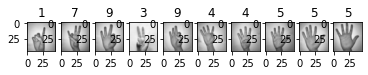

In [14]:
show((x_test,y_test), 10, 10)


In [15]:
#input_rows = np.array([199, 290, 214, 106, 15, 2, 0, 9, 5, 12, 1, 100, 150, 200, 250, 10, 13, 15, 19, 14])
input_rows = np.array([199, 290, 214, 106, 15, 2, 0, 9, 5, 12, 150, 10, 200, 13, 15, 19, 1, 100, 250, 14])
expected_labels = np.argmax(y_test[input_rows], axis=1)
print(input_rows)
print('expected',expected_labels)
y2_pred= model.predict(x_test_sc[input_rows])
print('predicted', np.argmax(y2_pred,axis=1))
print(x_test_sc[0].shape)

[199 290 214 106  15   2   0   9   5  12 150  10 200  13  15  19   1 100
 250  14]
expected [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
predicted [0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
(45, 45, 1)


In [16]:
RunSysCmd('rm -fr tmp && mkdir tmp')

#wmp = {'conv2d_1:0':'W_conv1', 'conv2d_1:1':'b_conv1', 'conv2d_2:0':'W_conv2', 'conv2d_2:1':'b_conv2',
#        'conv2d_3:0':'W_conv3', 'conv2d_3:1':'b_conv3', 'dense_1:0': 'W_fc1', 'dense_1:1': 'b_fc1'}

#lmp = {'conv2d_1':['conv1',None], 'activation_23':['relu1',None], 'max_pooling2d_24':['pool1',None],
#             'conv2d_2':['conv2',None], 'activation_24':['relu2',None], 'max_pooling2d_25':['pool2',None],
#             'conv2d_3':['conv3',None], 'activation_25':['relu3',None], 'max_pooling2d_26':['pool3',None],
#             'dense_1':['fc1',None], 'activation_26':['y',7]}

weights_header='weights'
parameters_header='parameters.h'
inputs_header='input'
fp = open(output + '/'+weights_header+'.h','w')
fp.close()
fp = open(output + '/'+inputs_header+'.h','w')
print(expected_labels)
fp.write('// Expected labels\nint expctd_lbl['+ str(len(expected_labels)) + '] = {', )
expected_labels.tofile(fp,sep=',',format='%d')
fp.write('};\n// Corresponding indexes in test data set\n//')
input_rows.tofile(fp,sep=',',format='%d')
fp.write('\n')
fp.close()
fp = open(output + '/'+parameters_header,'w')

for i in input_rows:
    qL,Q=save(x_test_sc[i],'input','IMAGE_DATA_'+str(i)+'_'+str(np.argmax(y_test[i])))
    fp.write('#define INPUT_%d_%d_Q %s\n'%(i,np.argmax(y_test[i]),Q))
    
print('layers in model',len(model.layers))

conv_indx=1
pool_indx=1
activ_indx=1
dense_indx=1
lmp = {}
wmp = {}
for layer in model.layers:    
    print('layer name::', layer.name, type(layer))
    if 'conv' in layer.name:        
        print('conv'+str(conv_indx))
        value = 'conv'+str(conv_indx)        
        lmp[layer.name] = [value, None]
        wmp[layer.name +':0'] = 'W_conv'+str(conv_indx)
        wmp[layer.name +':1'] = 'b_conv'+str(conv_indx)
        conv_indx+=1
    elif 'pool' in layer.name:
        print('pool'+str(pool_indx))
        value = 'pool'+str(pool_indx)        
        lmp[layer.name] = [value, None]
        pool_indx+=1    
    elif 'activation' in layer.name:
        print((layer.get_config())['activation'] + str(activ_indx))
        value = (layer.get_config())['activation'] + str(activ_indx)        
        lmp[layer.name] = [value, None]
        activ_indx+=1    
    elif 'dense' in layer.name:
        print('fc'+str(dense_indx))
        value = 'fc'+str(dense_indx)        
        lmp[layer.name] = [value, None]
        wmp[layer.name +':0'] = 'W_fc'+str(dense_indx)
        wmp[layer.name +':1'] = 'b_fc'+str(dense_indx)
        dense_indx+=1 

print(len(lmp.keys()), len(wmp.keys()))
print(lmp)
print(wmp)

  
for layer in model.layers:
    #if(layer.name in ['flatten_1','softmax_1']):continue
    if('flatten' in layer.name):continue
    if('activation' in layer.name):continue
    if('dropout' in layer.name): continue
        
    print(layer.name)
    layer_model = Model(inputs=model.input, outputs=layer.output)
    outR = layer_model.predict(x_test_sc[input_rows])
    print(outR.shape)
    qL,Q = save(outR,'tmpO')
    lmp[layer.name][1] = Q
    fp.write('#define %s_OUT_Q %s\n'%(lmp[layer.name][0].upper(), Q))

for layer in model.layers:
    for i, wt in enumerate(layer.get_weights()):
        name = wmp['%s:%s'%(layer.name,i)]
        print('keras generated shape',name, wt.shape)
        #show(wt, '%s %s(%s)'%(layer.name, name, wt.shape))
        if(len(wt.shape)==4):
            wt = wt.transpose(3, 0, 1, 2)            
            qL,Q = save(wt,'/'+weights_header,name.upper())
        elif(name in ['W_fc1', 'W_fc2']):
            wt = wt.transpose(1,0)
            wtq,Q = save(wt,'/'+weights_header,name.upper())
            wtq2 = convert_to_x4_q7_weights(wtq.reshape(wt.shape[0],wt.shape[1],1,1))
            print('wtq2 morphed shape', wtq2.shape)
            #wtq2.tofile('tmp/%s_opt.raw'%(name))   
            #wtq2.tofile(output+'/%s_opt.h'%(name), sep=',', format='%d')
            save_as_is(wtq2,'/'+weights_header,(name+'_opt').upper())
        else:
            qL,Q = save(wt,'/'+weights_header,name.upper())
        print('Morphed shape',name, wt.shape)
        #qL,Q = save(wt,name,name.upper())        
        fp.write('#define %s_Q %s\n'%(wmp['%s:%s'%(layer.name,i)].upper(), Q))
fp.close()    


[0 1 2 3 4 5 6 7 8 9 0 1 2 3 4 5 6 7 8 9]
layers in model 14
layer name:: conv2d_1 <class 'keras.layers.convolutional.Conv2D'>
conv1
layer name:: activation_4 <class 'keras.layers.core.Activation'>
relu1
layer name:: max_pooling2d_3 <class 'keras.layers.pooling.MaxPooling2D'>
pool1
layer name:: conv2d_2 <class 'keras.layers.convolutional.Conv2D'>
conv2
layer name:: activation_5 <class 'keras.layers.core.Activation'>
relu2
layer name:: max_pooling2d_4 <class 'keras.layers.pooling.MaxPooling2D'>
pool2
layer name:: dropout_2 <class 'keras.layers.core.Dropout'>
layer name:: conv2d_3 <class 'keras.layers.convolutional.Conv2D'>
conv3
layer name:: activation_6 <class 'keras.layers.core.Activation'>
relu3
layer name:: max_pooling2d_5 <class 'keras.layers.pooling.MaxPooling2D'>
pool3
layer name:: dropout_3 <class 'keras.layers.core.Dropout'>
layer name:: flatten_1 <class 'keras.layers.core.Flatten'>
layer name:: dense_1 <class 'keras.layers.core.Dense'>
fc1
layer name:: activation_7 <class 'ke